# Part D:

In [1]:
#importing all requried libraries
import os
import shutil
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.ops import box_iou

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and split

In [3]:
drive_path = '/content/drive/My Drive/dataset2/dataset2/'  # Change this to your dataset directory in Google Drive
original_images_path = drive_path + 'dataset2/images'
original_annotations_path = drive_path + 'dataset2/annotations'

In [4]:
if not os.path.exists(original_images_path) or not os.path.exists(original_annotations_path):
    raise FileNotFoundError("The specified dataset paths do not exist.")

# Define the paths for the train and test splits in Colab
train_images_path = '/content/train_images'
train_annotations_path = '/content/train_annotations'
test_images_path = '/content/test_images'
test_annotations_path = '/content/test_annotations'

In [ ]:
!ls '/content/drive/My Drive/dataset2/dataset2/dataset2'

annotations  images


In [5]:
# Create directories if they do not exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_annotations_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_annotations_path, exist_ok=True)

# List all image files
image_files = os.listdir(original_images_path)
annotation_files = os.listdir(original_annotations_path)

# Ensure the lists are sorted to maintain consistency
image_files.sort()
annotation_files.sort()

# Shuffle the image files
random.seed(42)
random.shuffle(image_files)

# Split into training and testing sets
train_files = image_files[:100]
test_files = image_files[100:]

# Debugging prints
print("Total images:", len(image_files))
print("Total annotations:", len(annotation_files))
print("Training images:", len(train_files))
print("Testing images:", len(test_files))

# Function to copy files to respective directories
def copy_files(file_list, src_img_dir, src_annot_dir, dest_img_dir, dest_annot_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_img_dir, file), dest_img_dir)
        annotation_file = file.replace('.jpg', '.xml')
        shutil.copy(os.path.join(src_annot_dir, annotation_file), dest_annot_dir)

# Copy training files
copy_files(train_files, original_images_path, original_annotations_path, train_images_path, train_annotations_path)

# Copy testing files
copy_files(test_files, original_images_path, original_annotations_path, test_images_path, test_annotations_path)

# Verify the contents of the train and test directories
train_images = os.listdir(train_images_path)
train_annotations = os.listdir(train_annotations_path)
test_images = os.listdir(test_images_path)
test_annotations = os.listdir(test_annotations_path)

# Additional debugging prints
print("Training Images Copied:", len(train_images))
print("Training Annotations Copied:", len(train_annotations))
print("Testing Images Copied:", len(test_images))
print("Testing Annotations Copied:", len(test_annotations))

if len(train_images) != 100 or len(test_images) != 28:
    raise ValueError("The data splitting process did not complete correctly.")
else:
    print("Data split into training and testing sets successfully.")

# Define the mapping of object labels
label_mapping = {
    'obj1': 'Can',
    'obj2': 'Tetra Pack',
    'obj3': 'Milk Bottle',
    'obj4': 'Water Bottle'
}

# Function to update annotations with proper labels
def update_annotations(annotations_path):
    for annotation_file in os.listdir(annotations_path):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_path, annotation_file)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                if label in label_mapping:
                    obj.find('name').text = label_mapping[label]
            tree.write(annotation_path)

# Update annotations for both train and test sets
update_annotations(train_annotations_path)
update_annotations(test_annotations_path)

print("Annotations updated successfully.")



Total images: 128
Total annotations: 128
Training images: 100
Testing images: 28
Training Images Copied: 100
Training Annotations Copied: 100
Testing Images Copied: 28
Testing Annotations Copied: 28
Data split into training and testing sets successfully.
Annotations updated successfully.


# Model Loading

In [8]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, img_dir, annot_dir, transforms=None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(img_dir)))
        self.annots = list(sorted(os.listdir(annot_dir)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        annot_path = os.path.join(self.annot_dir, self.annots[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            label = list(label_mapping.keys())[list(label_mapping.values()).index(name)]
            labels.append(int(label.replace('obj', '')))

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Define the dataset
train_dataset = CustomDataset(train_images_path, train_annotations_path, transforms=None)
test_dataset = CustomDataset(test_images_path, test_annotations_path, transforms=None)

# Test loading a few samples from the dataset
print("Testing dataset loading...")
for i in range(5):
    img, target = train_dataset[i]
    print(f"Image {i+1}: {img.shape}, Target: {target}")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one
num_classes = 5  # 4 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Evaluation function
def calculate_iou(pred_boxes, true_boxes):
    ious = box_iou(pred_boxes, true_boxes)
    return ious

def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    results = {class_name: {'TP': 0, 'FP': 0, 'FN': 0} for class_name in label_mapping.values()}

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to(device)
                pred_labels = output['labels'].to(device)

                true_boxes = targets[i]['boxes'].to(device)
                true_labels = targets[i]['labels'].to(device)

                for label in set(true_labels.tolist()):
                    pred_idx = pred_labels == label
                    true_idx = true_labels == label

                    pred_boxes_label = pred_boxes[pred_idx]
                    true_boxes_label = true_boxes[true_idx]

                    ious = calculate_iou(pred_boxes_label, true_boxes_label)

                    for iou in ious:
                        if iou.max().item() >= iou_threshold:
                            results[label_mapping[f'obj{label}']]['TP'] += 1
                        else:
                            results[label_mapping[f'obj{label}']]['FP'] += 1

                    results[label_mapping[f'obj{label}']]['FN'] += len(true_boxes_label) - len(ious)

    # Calculate precision and recall
    metrics = {}
    for class_name, result in results.items():
        tp = result['TP']
        fp = result['FP']
        fn = result['FN']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        metrics[class_name] = {'precision': precision, 'recall': recall}

    return metrics

Testing dataset loading...
Image 1: torch.Size([3, 666, 499]), Target: {'boxes': tensor([[100., 173., 233., 521.]]), 'labels': tensor([2])}
Image 2: torch.Size([3, 666, 499]), Target: {'boxes': tensor([[ 86., 102., 216., 439.],
        [150., 377., 445., 490.]]), 'labels': tensor([2, 3])}
Image 3: torch.Size([3, 666, 499]), Target: {'boxes': tensor([[130., 271., 367., 467.]]), 'labels': tensor([1])}
Image 4: torch.Size([3, 666, 499]), Target: {'boxes': tensor([[144., 260., 318., 429.]]), 'labels': tensor([1])}
Image 5: torch.Size([3, 666, 499]), Target: {'boxes': tensor([[175., 253., 355., 416.]]), 'labels': tensor([1])}


# Model Training

In [9]:
# Training loop with evaluation
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {losses.item()}")

    # Evaluate the model on the test set after each epoch
    metrics = evaluate_model(model, test_loader, device, iou_threshold=0.5)
    print(f"Epoch {epoch + 1} Evaluation Metrics:")
    for class_name, metric in metrics.items():
        print(f"Class: {class_name}, Precision: {metric['precision']:.2f}, Recall: {metric['recall']:.2f}")

print("Model fine-tuned and evaluated successfully.")

Epoch 1, Loss: 0.29108163714408875
Epoch 1 Evaluation Metrics:
Class: Can, Precision: 0.26, Recall: 0.00
Class: Tetra Pack, Precision: 0.23, Recall: 0.00
Class: Milk Bottle, Precision: 0.31, Recall: 0.00
Class: Water Bottle, Precision: 0.33, Recall: 0.00
Epoch 2, Loss: 0.16662603616714478
Epoch 2 Evaluation Metrics:
Class: Can, Precision: 0.44, Recall: 0.00
Class: Tetra Pack, Precision: 0.36, Recall: 0.00
Class: Milk Bottle, Precision: 0.36, Recall: 0.00
Class: Water Bottle, Precision: 0.30, Recall: 0.00
Epoch 3, Loss: 0.15496250987052917
Epoch 3 Evaluation Metrics:
Class: Can, Precision: 0.53, Recall: 10.50
Class: Tetra Pack, Precision: 0.38, Recall: 0.00
Class: Milk Bottle, Precision: 0.52, Recall: 0.00
Class: Water Bottle, Precision: 0.35, Recall: 0.00
Epoch 4, Loss: 0.1069406270980835
Epoch 4 Evaluation Metrics:
Class: Can, Precision: 0.60, Recall: 3.00
Class: Tetra Pack, Precision: 0.43, Recall: 0.00
Class: Milk Bottle, Precision: 0.58, Recall: 3.75
Class: Water Bottle, Precision:

# Model Test

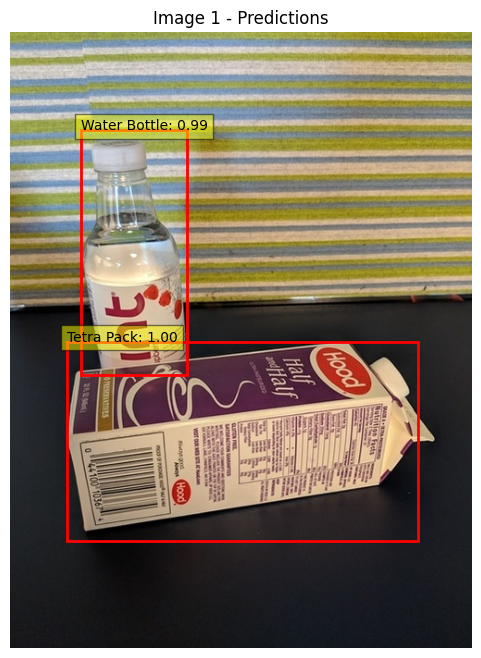

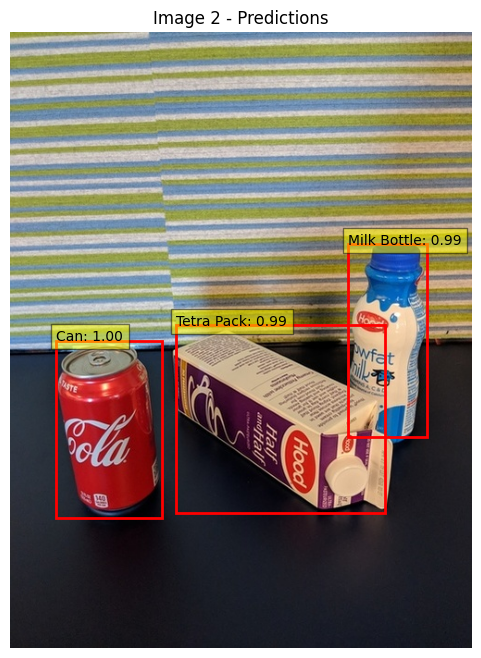

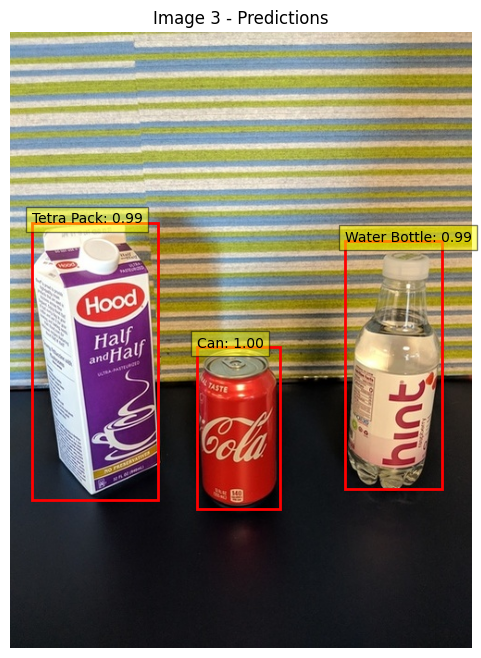

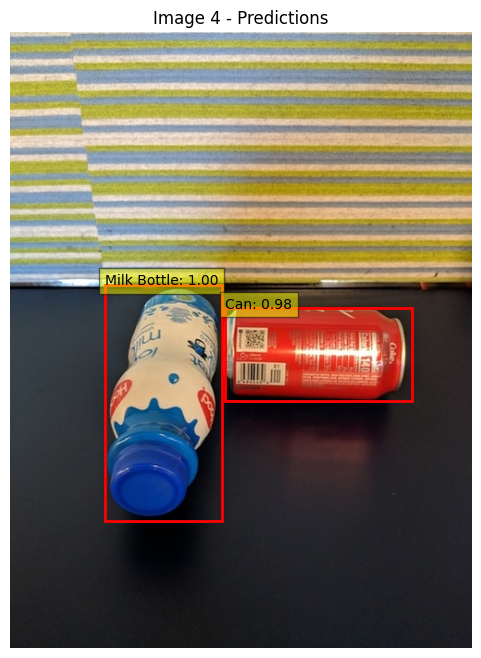

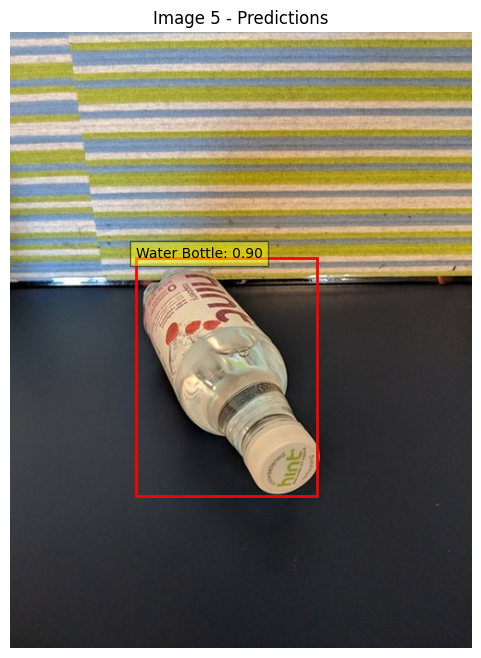

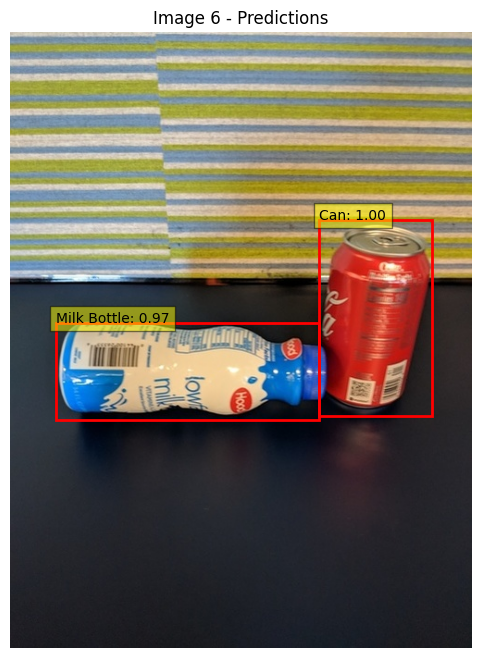

Predictions on 6 random images completed.


In [10]:
# Create reverse label mapping for displaying correct class names
reverse_label_mapping = {1: 'Can', 2: 'Tetra Pack', 3: 'Milk Bottle', 4: 'Water Bottle'}

# Visualization of random predictions (for visualization purposes)
random_indices = random.sample(range(len(test_dataset)), 6)
model.eval()
with torch.no_grad():
    for i, idx in enumerate(random_indices):
        img, _ = test_dataset[idx]
        img = img.to(device)
        prediction = model([img])

        # Convert tensor image to numpy
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot image with bounding boxes
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        ax = plt.gca()

        for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
            if score > 0.5:  # Threshold for displaying boxes
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
                ax.add_patch(rect)
                class_name = reverse_label_mapping[label.item()]
                ax.text(xmin, ymin, f'{class_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

        plt.title(f'Image {i+1} - Predictions')
        plt.axis('off')
        plt.show()

print("Predictions on 6 random images completed.")


Inferences: 

•	Trained the model over 10 epochs. The loss was reduced significantly over the epochs. Finally, it achieved a validation loss of 0.03. This shows that the model is able to make accurate predictions.

•	The precision values are higher across all classes. Class water bottles and tetra packs can have higher values than a milk bottle.

•	The recall values fluctuated over the epochs across classes. 

•	Since we give higher weightage to false positives in this model, we can consider precision over recall. Precision gives importance to false positives rather than false negatives.
